# S04 T01: Transformació Registre Log amb Regular expressions

### Descripció

L'anàlisi de registres és una funció important per al control i l'alerta, el compliment de les polítiques de seguretat, l'auditoria i el compliment normatiu, la resposta a incidents de seguretat i fins i tot les investigacions forenses. En analitzar les dades de registre, les empreses poden identificar més fàcilment les possibles amenaces i altres problemes, trobar la causa arrel i iniciar una resposta ràpida per mitigar els riscos. 

### Nivell 1

L'analista ha d'assegurar-se que els registres consisteixen en una gamma completa de missatges i s'interpreten segons el context. Els elements de registre han d'estandaritzar-se, utilitzant els mateixos termes o terminologia, per evitar confusions i proporcionar cohesió.

Com Científic de Dades se t'ha proporcionat accés als registres-Logs on queda registrada l'activitat de totes les visites a realitzades a la pàgina web de l'agència de viatges "akumenius.com".

#### Exercici 1

Estandaritza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources". 

In [1]:
import re
import pandas as pd
import numpy as np
import datetime as dt
import json
from ip2geotools.databases.noncommercial import DbIpCity
import warnings

# Libraries for do some visualizations in Exercici 3
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')

In [2]:
file = open("Web_access_log-akumenius.com.txt", "r")

In [3]:
# Print first line to see the structure of a log file line
print(file.readline())

localhost 127.0.0.1 - - [23/Feb/2014:03:10:31 +0100] "OPTIONS * HTTP/1.0" 200 - "-" "Apache (internal dummy connection)" VLOG=-



I can identify the following parts:

1. **web host**: localhost 
2. **IP** address of the client (remote host): 127.0.0.1
3. **identd** on the clients machine: -
4. **userid** of the person requesting the document: -
5. **date and time** that the request was received - [23/Feb/2014:03:10:31 +0100]
6. **request** from the client. Contains:
    - the method used by the client: OPTIONS
    - resource requested: *
    - protocol used by the client: HTTP/1.0


7. **status** code that the server sends back to the client: 200
8. **size** of the object returned to the client: -
9. **referer** (sic) HTTP request header. This gives the site that the client reports having been referred from: -
10. **User-Agent** HTTP request header. This is the identifying information that the client browser reports about itself: Apache (internal dummy connection
11. **vlog**: VLOG=-

### Nivell 2

#### Exercici 2

Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

All parts are separated by a white space, so I will create diferent regular expression to capture each part as a group and then join them using a white space. I use a function that returns a dictionary that has as keys the name of the part of the log file and as value the string

In [4]:
parts = [
    r'^(?P<host>\S+)',                  # host
    r'(?P<ip>\S+)',                     # ip
    r'(?P<indent>\S+)',                 # indentd
    r'(?P<user>\S+)',                   # user
    r'\[(?P<datetime>.+)\]',            # time
    r'"(?P<request>.+)"',               # request
    r'(?P<status>[0-9]+)',              # status
    r'(?P<size>\S+)',                   # size
    r'"(?P<referer>.*)"',               # referer
    r'"(?P<agent>.*)"',                 # user agent
    r'(?P<vlog>\S+)',                   # vlog
]

# Pattern to get the 3 infos contained in the request string: methos, resource and protocol
request_pattern = re.compile(r"(?P<method>.+)\s(?P<resource>\S+)\s(?P<protocol>\S+)")
pattern = re.compile(r'\s+'.join(parts))

In [5]:
# Function that receives a log line as parameter and returns a dictionary with all the variables
def logline_to_dict(line):
    match = pattern.match(line)
    result = match.groupdict()
    return result

After that, I transform the dates string into a datetime object. First I transform the Spanish month names in numbers

In [6]:
# Transform the values of the "time" column to datetime

# Dictionary to transform abbreviated Spanish months in numbers

months = {"Ene":"01", "Feb":"02", "Mar":"03", "Abr":"04", "May": "05", "Jun": "06", 
          "Jul": "07", "Ago":"08","Sep":"09","Oct":"10","Nov":"11","Dic":"12"}

# Function that transforms the time string in datetime object
def transform_time(time):
    pattern = re.compile('|'.join(months.keys()))
    t = pattern.sub(lambda x: months[x.group()], time)
    t = dt.datetime.strptime(t, '%d/%m/%Y:%H:%M:%S %z')
    return (t)

In [7]:
# Example of a dictionary created from log line
logline_to_dict(file.readline())

{'host': 'localhost',
 'ip': '127.0.0.1',
 'indent': '-',
 'user': '-',
 'datetime': '23/Feb/2014:03:10:31 +0100',
 'request': 'OPTIONS * HTTP/1.0',
 'status': '200',
 'size': '-',
 'referer': '-',
 'agent': 'Apache (internal dummy connection)',
 'vlog': 'VLOG=-'}

In [8]:
# Go back to first line of the file
file.seek(0)

0

In [9]:
# Parse the whole file, read every line as a dictionary and store it in a list
line = file.readline()

log_lines = []

while line:
    try:
        req_dict = {"method":None, "resource":None, "protocol":None}
        log_dict = logline_to_dict(line)
        
        log_dict["datetime"] = transform_time(log_dict["datetime"])
        
        req_match = request_pattern.match(log_dict["request"])
        
        if req_match != None:
            req_dict = req_match.groupdict()
            
        log_dict.update(req_dict)
        
        # Cahanfe "-" fields for the value np.nan
        log_dict = {k:(v if v != "-" else np.nan) for k,v in log_dict.items()}
        
        log_lines.append(log_dict)
        line = file.readline()
    except:
        print(line)

Create a dataframe from the list of dicts

In [10]:
df = pd.DataFrame(log_lines, columns = ['host', 'ip', 'indent', 'user', 'datetime', 
                                        'request', 'method', 'resource', 'protocol', 
                                        'status', 'size', 'referer', 'agent', 'vlog'])

In [11]:
# Transform size from string to numeric value
df["size"] = pd.to_numeric(df["size"])

In [12]:
df.head(5)

,host,ip,indent,user,datetime,request,method,resource,protocol,status,size,referer,agent,vlog
0,localhost,127.0.0.1,NaN,NaN,2014-02-23 03:10:31+01:00,OPTIONS * HTTP/1.0,OPTIONS,*,HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),VLOG=-
1,localhost,127.0.0.1,NaN,NaN,2014-02-23 03:10:31+01:00,OPTIONS * HTTP/1.0,OPTIONS,*,HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),VLOG=-
2,localhost,127.0.0.1,NaN,NaN,2014-02-23 03:10:31+01:00,OPTIONS * HTTP/1.0,OPTIONS,*,HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),VLOG=-
3,localhost,127.0.0.1,NaN,NaN,2014-02-23 03:10:31+01:00,OPTIONS * HTTP/1.0,OPTIONS,*,HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),VLOG=-
4,localhost,127.0.0.1,NaN,NaN,2014-02-23 03:10:31+01:00,OPTIONS * HTTP/1.0,OPTIONS,*,HTTP/1.0,200,NaN,NaN,Apache (internal dummy connection),VLOG=-


#### Exercici 3

Geolocalitza les IP's.

I created a dictionary containing the geolocalitation info from ip2geotools. I used the unique values of the "ip" column of the dataset. Because this process takes a lot of time I did it one time and saved the dictionary to a json file, so I can read it faster if I need to work with this data on different days

In [13]:
ip_file = open("ip_geo.json", "r")
ips_dictionary = json.load(ip_file)

In [14]:
def localitation_info(ip, key):
    info = ips_dictionary[ip]
    return info[item][0]

In [15]:
# Add the columns with the geolocalitation info to the DataFrame
for item in ["city", "region", "country", "latitude", "longitude"]:
    df[item] = df["ip"].apply(localitation_info, key=item)

In [16]:
df[["ip", "city", "region", "country", "latitude", "longitude"]].sample(5)

,ip,city,region,country,latitude,longitude
41981,66.249.76.216,Mountain View,California,US,37.389389,-122.083210
126784,77.27.141.43,None,None,None,NaN,NaN
80541,92.56.114.50,Pozuelo de Alarcón,Madrid,ES,40.434653,-3.814834
165192,80.35.176.249,None,None,None,NaN,NaN
164967,195.53.184.207,None,None,None,NaN,NaN


### Nivell 3

#### Exercici 3

Mostra'm la teva creativitat. Sorprèn-me fes un pas més enllà amb l'anàlisi anterior.

I´m going to do some visualizations using this data to get a visual information

#### Visualization of the number of visits per country

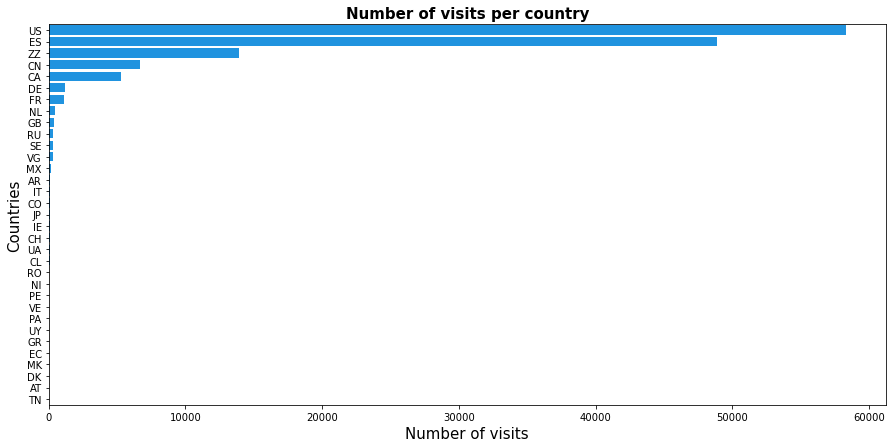

In [17]:
# Number of visits for countries

# New dataframe grouped by country
countries = df.groupby("country").size().sort_values(ascending=False).reset_index(name='total')

plt.figure(figsize=(15,7))

ax = sns.barplot(y="country", x="total", data=countries, 
                 color="#0099ff")

ax.set_title("Number of visits per country", fontsize="15", weight="bold")
ax.set_xlabel("Number of visits", fontsize="15")
ax.set_ylabel("Countries", fontsize="15")

plt.show()

We can see that most of the visits come from the US or Spain. ZZ, the 3rd country, is the code used for Unknown or unspecified countries

I want to analyse date and time related data. For this reason I create a DataFrame with the timestamp of the column datetime splitted in month, day, year, weekday, hour, minute, date and time

In [18]:
time_df = pd.DataFrame({"month": df["datetime"].apply(lambda x: x.month),
              "day": df["datetime"].apply(lambda x: x.day),
              "year": df["datetime"].apply(lambda x: x.year),
              "weekday": df["datetime"].apply(lambda x: x.strftime('%a')),
              "hour": df["datetime"].apply(lambda x: x.hour),
              "minute": df["datetime"].apply(lambda x: x.minute),
              "date": df["datetime"].apply(lambda x: x.date()),
              "time": df["datetime"].apply(lambda x: x.time())
             }
)

New DataFrame with the total of visits per day

In [19]:
month_day = time_df.groupby("date").size().reset_index(name="total")
month_day.head()

,date,total
0,2014-02-23,40536
1,2014-02-24,48850
2,2014-02-25,55798
3,2014-02-26,36473
4,2014-02-27,41513


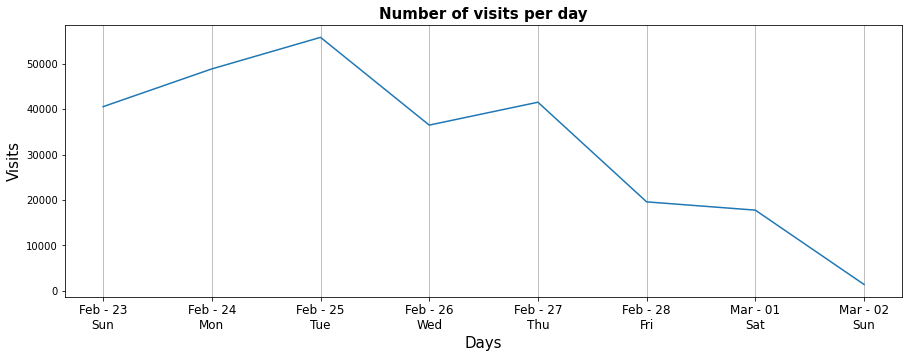

In [20]:
# Number of visits per day

# Create the figure
fig, ax = plt.subplots(figsize=(15,5))

# The data that I want to show
day = month_day["date"]
total = month_day["total"]

# Create a format to show the dates in the x-axis
month_day_formatter = mdates.DateFormatter('%b - %d\n%a')
ax.xaxis.set_major_formatter(month_day_formatter)

# Add vertical grid lines
ax.grid(axis="x")

# Set title and axis labels
ax.set_title("Number of visits per day", fontsize="15", weight="bold")
ax.set_xlabel("Days", fontsize="15")
ax.set_ylabel("Visits", fontsize="15")

# Plot the line
ax = sns.lineplot(x=day, y=total)

# Set font size of the x ticks
plt.xticks(fontsize="12")

plt.show()

I can see that during the first 3 days the number of visits increases. After that, this number decreases with only few visits the last day.

Now I want to see if there is a difference in the days of the visits of the 6 countries with most visits

In [21]:
# Add column country to time_df
time_df["country"] = df["country"]

In [22]:
# New df with the info grouped by date and country to show the info of the visits for the 6 countries with more visits
new_df = time_df.groupby(["date", "country"]).size().reset_index(name="total")

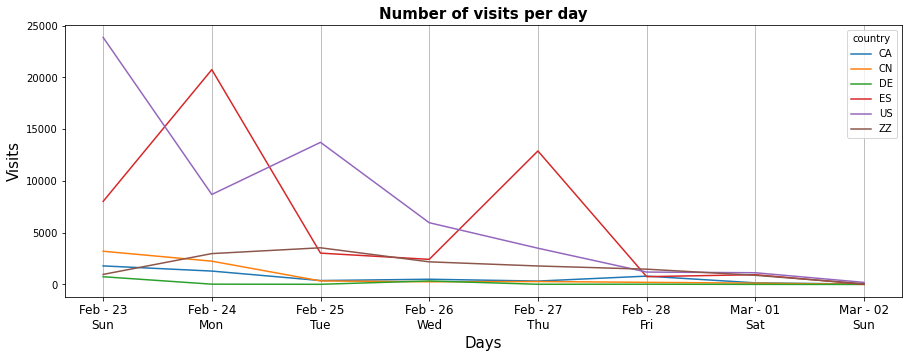

In [23]:
# Number of visits per day

# Create the figure
fig, ax = plt.subplots(figsize=(15,5))

# Create a DataFrame with the 6 countries with more visits
data = new_df[new_df["country"].isin(countries["country"].values[:6])]

# Create a format to show the dates in the x-axis
month_day_formatter = mdates.DateFormatter('%b - %d\n%a')
ax.xaxis.set_major_formatter(month_day_formatter)

# Add vertical grid lines
ax.grid(axis="x")

# Set title and axis labels
ax.set_title("Number of visits per day", fontsize="15", weight="bold")
ax.set_xlabel("Days", fontsize="15")
ax.set_ylabel("Visits", fontsize="15")

# Plot the line
ax = sns.lineplot(x="date", y="total", hue="country", data=data)

# Set font size of the x ticks
plt.xticks(fontsize="12")

plt.show()

I think it´s interesting that there isn´t a big difference for the last 4 countries, only the ZZ (Unknown country) seems to have a different behaviour. But the number of visits for Spain and the US seems to have an opposite pattern. When there are more visits in Spain, there are less in the US. In Spain there are two days with more visits that are Feb 24 (Monday) and Feb 27 (Thursday) but for the US are Feb 23 (Sunday) and Feb 25 (Tuesday) the days with more visits.

Another way to see this information is using a FacetGrid. There we can see the info for every country

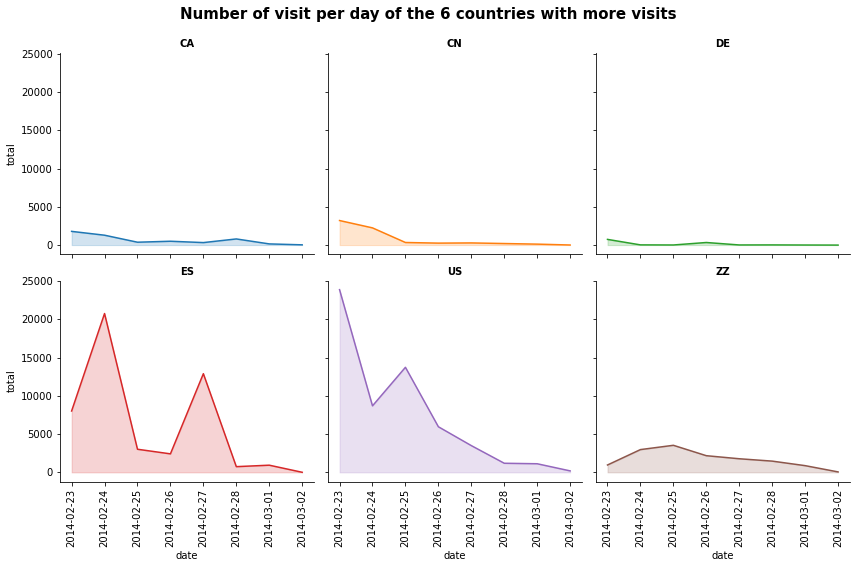

In [24]:
# Number of visit per day of the 6 countries with more visits

# Create the FacetGrid
g = sns.FacetGrid(data, col='country', hue='country', col_wrap=3, height=4)

# Plot the line
g = g.map(plt.plot, 'date', 'total')

month_day_formatter = mdates.DateFormatter('%b - %d')
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(month_day_formatter)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
# Use fill_between to fill the shapes
g = g.map(plt.fill_between, 'date', 'total', alpha=0.2).set_titles("{col_name} country")
 
# Set the title for each facet
g = g.set_titles("{col_name}", weight="bold")
 
# Set a title
plt.subplots_adjust(top=0.9)
g = g.fig.suptitle('Number of visit per day of the 6 countries with more visits', fontsize="15", weight="bold")

plt.show()

Now I want to see the distribution per hours of the visits on the same 6 countries. To do that I´m going to use an histogram

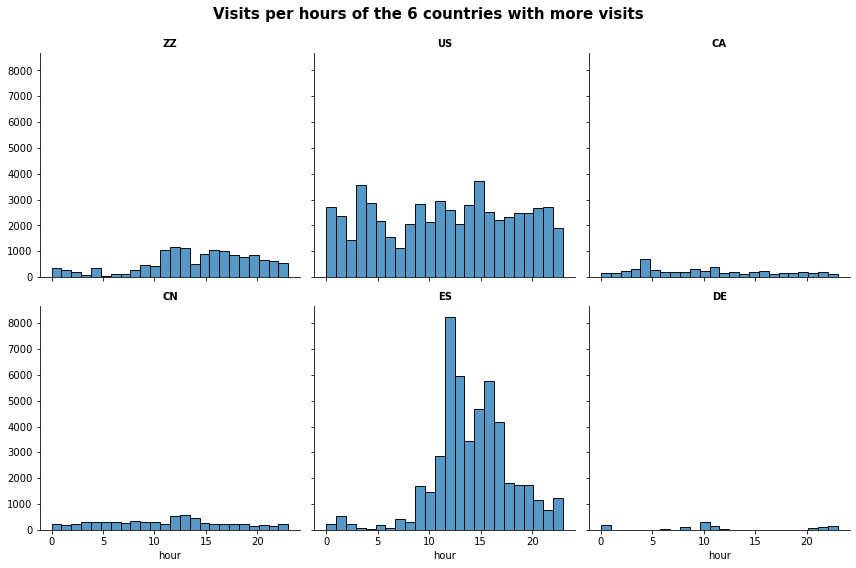

In [25]:
# Visits per hours of the 6 countries with more visits

n_data = time_df[time_df["country"].isin(countries["country"].values[:6])]

g = sns.FacetGrid(n_data, col="country", col_wrap=3, height=4)
g.map(sns.histplot, "hour", bins=24)

# Control the title of each facet
g = g.set_titles("{col_name}", weight="bold")

# Add a title for the whole plot
plt.subplots_adjust(top=0.9)
g = g.fig.suptitle('Visits per hours of the 6 countries with more visits', fontsize="15", weight="bold")

plt.show()

I can see that in Spain there are more visits around 12h and 16h. Something that surprised me it´s to see that one of the hour with most visits in Germany it´s around 4 because I think it´s too early. There are no big differences in the hours for the US. This could be because there are many time zones in the US.

Now I want to take a look at the status code to see if there was some issues or errors. First I want to see the number of the differents status types per day and hour

In [26]:
# Create a copy of df
df2 = df.copy()

In [27]:
# Add the column date to df2
df2["date"] = time_df["date"]

In [28]:
def status_type(status):
    status_types = {"1":"Informational", "2":"Success", "3":"Redirection", "4":"Client Error", "5":"Server Error"}
    first_num = status[0]
    return status_types[first_num]

In [29]:
df2["status_type"] = df2["status"].apply(status_type)
df2["hour"] = time_df["hour"]

In [30]:
date_status = df2.groupby(["date", "hour", "status_type"]).size().reset_index(name="total")
date_status.head()

,date,hour,status_type,total
0,2014-02-23,3,Client Error,744
1,2014-02-23,3,Redirection,7
2,2014-02-23,3,Success,1475
3,2014-02-23,4,Client Error,141
4,2014-02-23,4,Redirection,1


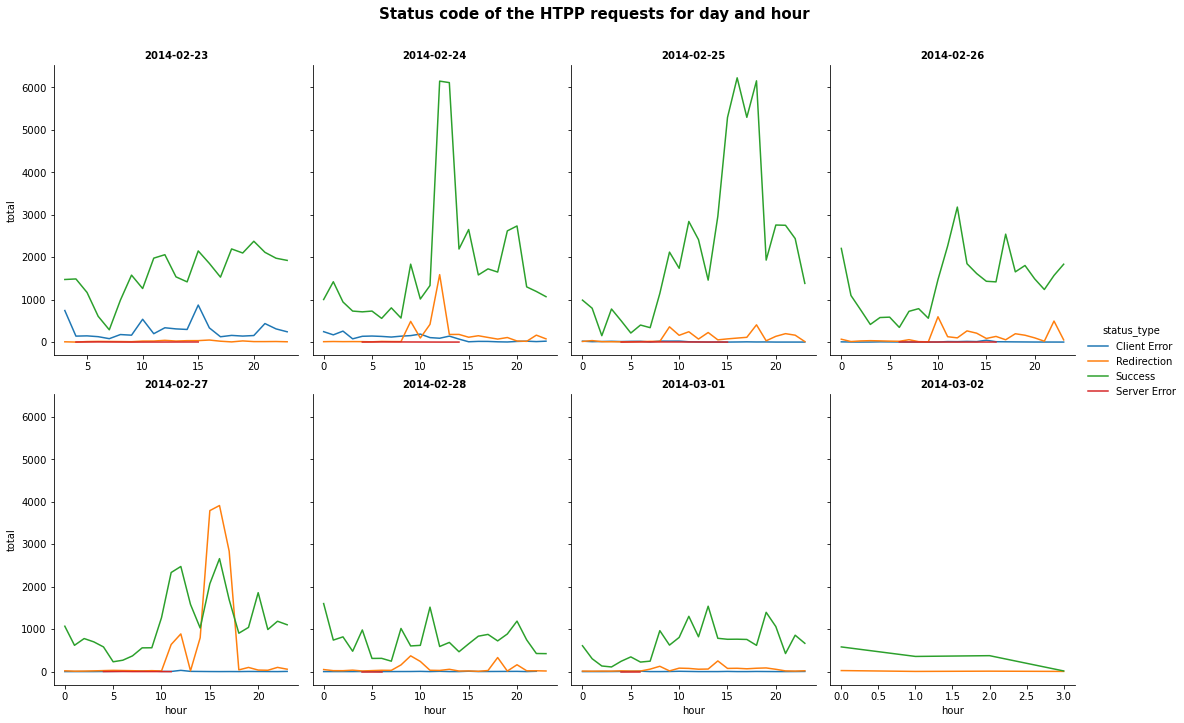

In [31]:
# Status code of the HTPP requests for day and hour

g = sns.relplot(
    data=date_status,
    x="hour", y="total", col="date", col_wrap=4,
    hue="status_type", kind="line", size_order=["T1", "T2"], 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

# Control the title of each facet
g = g.set_titles("{col_name}", weight="bold")

# Add a title for the whole plot
plt.subplots_adjust(top=0.9)
g = g.fig.suptitle('Status code of the HTPP requests for day and hour', fontsize="15", weight="bold")
    
plt.show()

There are 2 things that surprise me. On one hand, on the 27 Feb I see that around 15h there are more redirection status than Success status. On the other hand, I see that on 23 Feb there rate of Client errors is higher than the other days. So I´m going to take a look at that day to get more information. I would like to see at which hour the errors were higher and the type of Client error 

In [32]:
date_error = df2[(df2["date"] == dt.date(2014, 2, 23)) & (df2["status_type"] == "Client Error")]

In [33]:
dt_error = date_error.groupby(["hour", "status"]).size().reset_index(name="total")

In [34]:
dt_error.head()

,hour,status,total
0,3,404,744
1,4,404,141
2,5,403,1
3,5,404,146
4,6,404,128


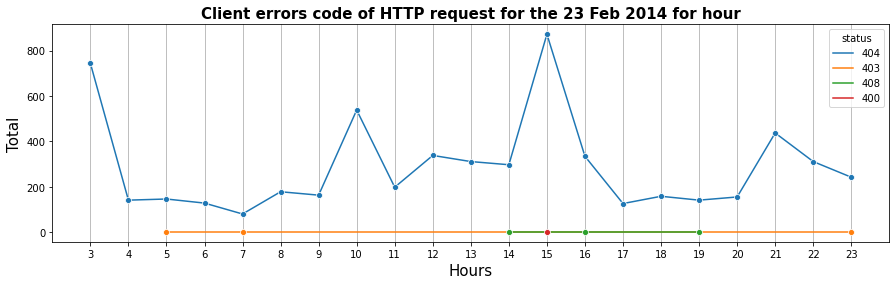

In [35]:
# Show the different Client errors code of HTTP request for the 23 Feb for hour

plt.figure(figsize=(15,4))

ax = sns.lineplot(x="hour", y="total", hue="status", data=dt_error, marker="o")

ax.set_title("Client errors code of HTTP request for the 23 Feb 2014 for hour", fontsize="15", weight="bold")
ax.set_xlabel("Hours", fontsize="15")
ax.set_ylabel("Total", fontsize="15")

plt.xticks(range(dt_error["hour"].min(), dt_error["hour"].max()+1))

plt.grid(axis="x")

plt.show()

I can see that most Client errors correspond to the code 404. And between 14h and 16h is were most of them ocurred 

Now I want to take a look at the ips that have most visits that day to see if all of them experienced the same error at that time

In [36]:
most_ips = date_error.groupby("ip").size().sort_values(ascending=False).index[:5]

In [37]:
data = date_error[date_error["ip"].isin(most_ips)].groupby(["ip","hour"]).size().reset_index(name="total")

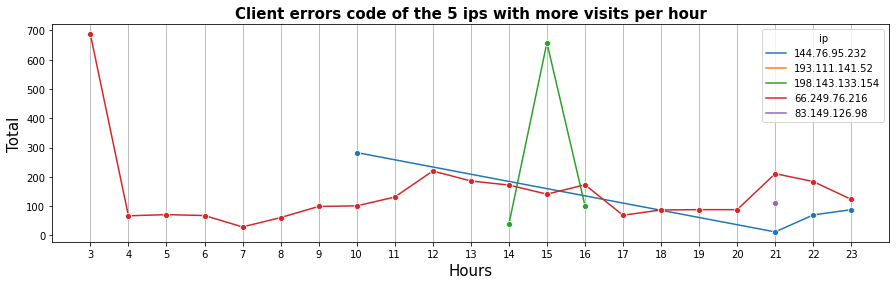

In [38]:
# Show the Client errors of the 5 ips with more visits and the hours when they ocurred

plt.figure(figsize=(15,4))

ax = sns.lineplot(x="hour", y="total", hue="ip", data=data, marker="o")

ax.set_title("Client errors code of the 5 ips with more visits per hour", fontsize="15", weight="bold")
ax.set_xlabel("Hours", fontsize="15")
ax.set_ylabel("Total", fontsize="15")

plt.xticks(range(data["hour"].min(), data["hour"].max()+1))

plt.grid(axis="x")

plt.show()

I find it surprising the higher rate of client errors for the ip 198.143.133.154 between 14h and 16h. It seems that only this ip experienced these errors. This is not usual and it should be analysed with more detail